# Analysis of Charging Infrastructure in Germany

To reduce CO₂ emissions, the European Union has enacted a law banning the sale of new petrol and diesel cars starting in 2035. This transition will significantly increase the demand for electric vehicles (EVs) and, consequently, for charging infrastructure.

# Question

The key question is: Is Germany prepared for this shift? Does the country have the necessary charging infrastructure to support the growing number of electric vehicles, or are there critical gaps that need to be addressed?

# Datasets

- `Car registrations in Germany`:
https://www.kba.de/DE/Statistik/Produktkatalog/produkte/Fahrzeuge/fz27_b_uebersicht.html?nn=4543062

- `Charging stations in Germany`:
https://www.bundesnetzagentur.de/DE/Fachthemen/ElektrizitaetundGas/E-Mobilitaet/Ladesaeulenkarte/start.html

- `Gas Stations`: 
https://www.bft.de/daten-und-fakten/entwicklung-tankstellenanzahl

- `Population`:
https://www.statistikportal.de/de/bevoelkerung/flaeche-und-bevoelkerung


# Environment Setup

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.ticker import FuncFormatter

import warnings
warnings.filterwarnings('ignore')


import sys
sys.path.insert (0, './_functions_/')
from functions_electric_cars import *
from utils import *

In [2]:
df = pd.read_csv('./raw_data/charging_stations_per_state.csv')
df

,land,regular_charging_points,fast_charging_points,number_of_charging_points,year
0,Baden-Württemberg,"1,106",241,"1,347",2018
1,Bayern,"2,138",363,"2,501",2018
2,Berlin,612,26,638,2018
3,Brandenburg,88,28,116,2018
4,Bremen,67,4,71,2018
...,...,...,...,...,...
131,Sachsen,"4,373","1,424","5,797",2025
132,Sachsen-Anhalt,"1,840",910,"2,750",2025
133,Schleswig-Holstein,"5,017","1,499","6,516",2025
134,Thüringen,"2,154","1,157","3,311",2025


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   land                       136 non-null    object
 1   regular_charging_points    136 non-null    object
 2   fast_charging_points       136 non-null    object
 3   number_of_charging_points  136 non-null    object
 4   year                       136 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 5.4+ KB


# Data wrangling

Corrected data types

In [4]:
df["regular_charging_points"] = df["regular_charging_points"].str.replace(",", "").astype(int)
df["fast_charging_points"] = df["fast_charging_points"].str.replace(",", "").astype(int)
df["number_of_charging_points"] = df["number_of_charging_points"].str.replace(",", "").astype(int)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   land                       136 non-null    object
 1   regular_charging_points    136 non-null    int64 
 2   fast_charging_points       136 non-null    int64 
 3   number_of_charging_points  136 non-null    int64 
 4   year                       136 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 5.4+ KB


In [6]:
df['land'].value_counts()

land
Baden-Württemberg         8
Bayern                    8
Berlin                    8
Brandenburg               8
Bremen                    8
Hamburg                   8
Hessen                    8
Mecklenburg-Vorpommern    8
Niedersachsen             8
Nordrhein-Westfalen       8
Rheinland-Pfalz           8
Saarland                  8
Sachsen                   8
Sachsen-Anhalt            8
Schleswig-Holstein        8
Thüringen                 8
Deutschland               8
Name: count, dtype: int64

In [7]:
df_germany = df[df["land"] == 'Deutschland']
df_germany.to_csv('./clean_data/stations_germany.csv', index = False)


Plots the number of charging points over time

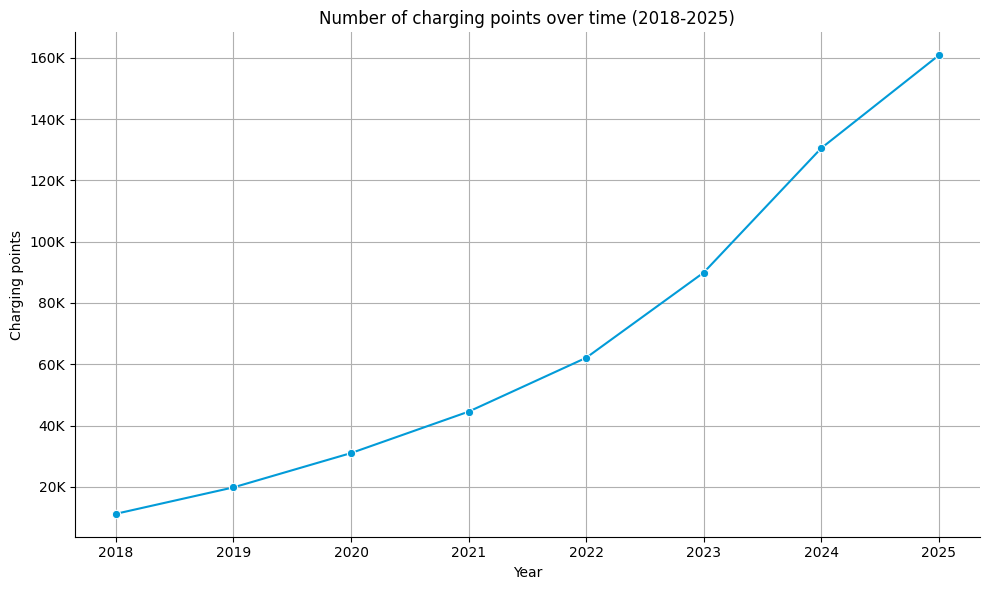

In [8]:
yearly_counts = df_germany["number_of_charging_points"].sort_index()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data = df_germany, x="year", y = yearly_counts, marker='o', color = "#029BD8" )
sns.despine()
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_millions_formatter))

plt.title("Number of charging points over time (2018-2025)")
plt.xlabel("Year")
plt.ylabel("Charging points")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Count the number of stations per state
df_only_states = df[~(df["land"] == "Deutschland")]
df_only_states


,land,regular_charging_points,fast_charging_points,number_of_charging_points,year
0,Baden-Württemberg,1106,241,1347,2018
1,Bayern,2138,363,2501,2018
2,Berlin,612,26,638,2018
3,Brandenburg,88,28,116,2018
4,Bremen,67,4,71,2018
...,...,...,...,...,...
130,Saarland,942,286,1228,2025
131,Sachsen,4373,1424,5797,2025
132,Sachsen-Anhalt,1840,910,2750,2025
133,Schleswig-Holstein,5017,1499,6516,2025


In [10]:
# Count the number of stations per state
stations_per_state = df_only_states.groupby("land").agg(
    number_of_stations=("number_of_charging_points", "sum")     
).reset_index()

stations_per_state

,land,number_of_stations
0,Baden-Württemberg,93695
1,Bayern,111983
2,Berlin,18854
3,Brandenburg,12340
4,Bremen,3969
5,Hamburg,14077
6,Hessen,41655
7,Mecklenburg-Vorpommern,6887
8,Niedersachsen,54124
9,Nordrhein-Westfalen,101969


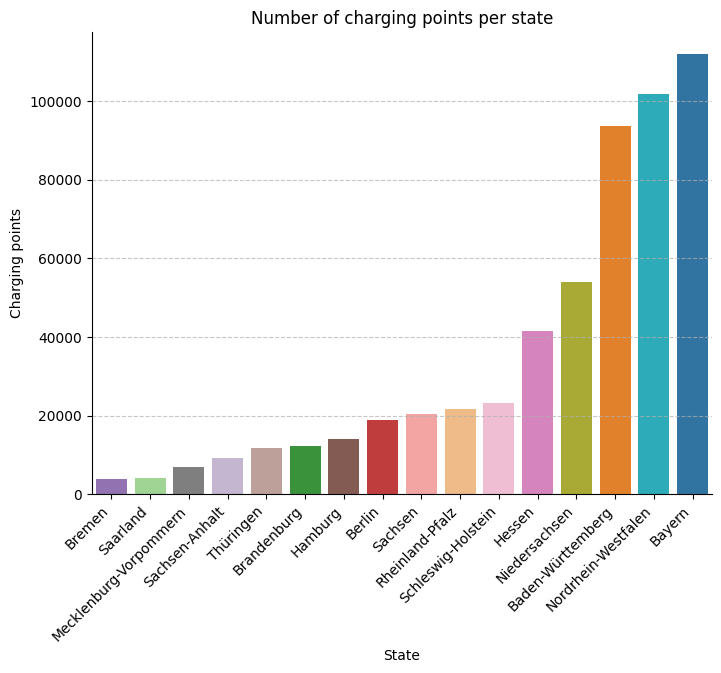

In [12]:
# Create the plot
plt.figure(figsize=(8, 6))

stations_per_state.sort_values(by = "number_of_stations", inplace=True)
sns.barplot(data=stations_per_state, x="land", y="number_of_stations", palette=german_states_colors)
sns.despine()

plt.title("Number of charging points per state")
plt.xlabel("State")
plt.ylabel("Charging points")

plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

## Create a Summary Dataframe

Groups number of charging stations, number of charging points, number of fast charging stations, number of regular charging stations per state

In [13]:
# Create the summary DataFrame
df_stations_per_state = df_only_states.groupby("land").agg(
    number_of_charging_points=("number_of_charging_points", "sum"),    
    number_fast_charging_stations=("fast_charging_points", "sum"),
    number_regular_charging_stations=("regular_charging_points", "sum")
).reset_index()


df_stations_per_state.head()


,land,number_of_charging_points,number_fast_charging_stations,number_regular_charging_stations
0,Baden-Württemberg,93695,14271,79424
1,Bayern,111983,19649,92334
2,Berlin,18854,2325,16529
3,Brandenburg,12340,2897,9443
4,Bremen,3969,537,3432


In [14]:
df_stations_per_state.rename(columns = {"land":"state"}, inplace = True)
df_stations_per_state.to_csv('./clean_data/stations_per_state.csv', index=False)

## Predicting future

Plots the current values and the predictions

In [18]:
def plot_prediction (df, future_years):
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["year"], df["number_of_charging_points"], label="Actual", marker="o")
    
    # Plot projection
    plt.plot(future_years.flatten(), predictions, linestyle="--", label="Trend Projection")
    
    # Formatting
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_formatter(FuncFormatter(thousands_millions_formatter))
    
    
    
    plt.title("Charging points growth & prediction for 2030")
    plt.xlabel("Year")
    plt.ylabel("Number of charging points")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Linear Regression

In case the number of new stations continues to grow at the same pace as in the last years

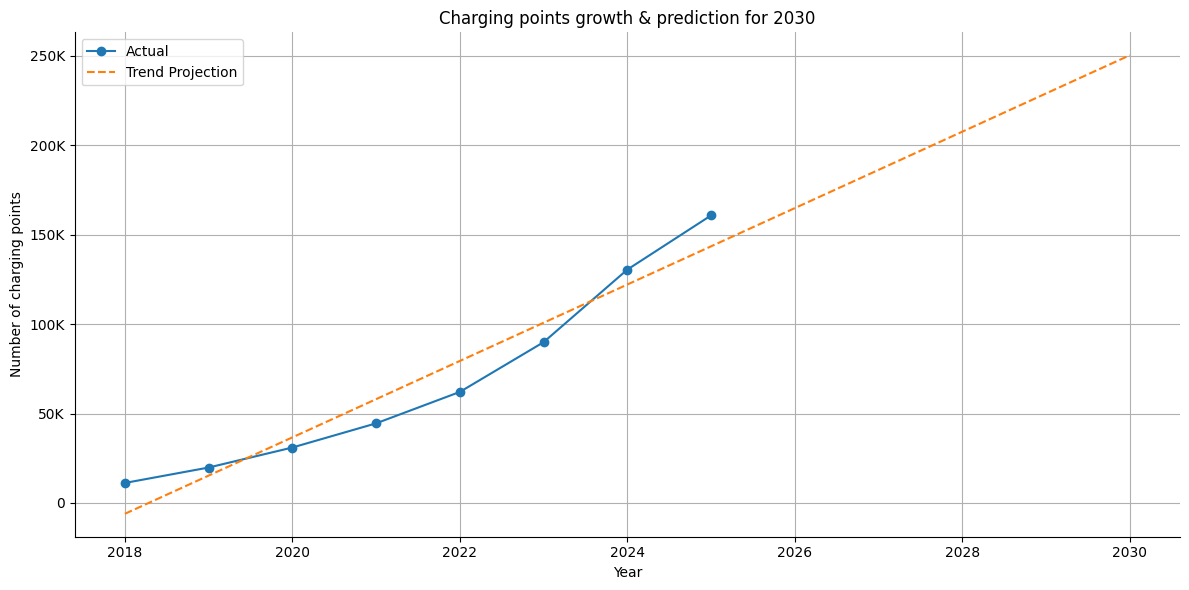

To reach 1,000,000 stations by 2030, Germany needs ~167,838 new stations per year from 2026.


In [19]:
df = df_germany.copy()

# Step 1: Linear regression for projection
X = df["year"].values.reshape(-1, 1)
y = df["number_of_charging_points"].values

model = LinearRegression()
model.fit(X, y)

# Predict future until 2030
future_years = np.arange(df["year"].min(), 2031).reshape(-1, 1)
predictions = model.predict(future_years)

# Calculate remaining needed to hit the 2030 target
last_known_year = df["year"].max()
last_known_count = df[df["year"] == last_known_year]["number_of_charging_points"].values[0]
stations_needed = 1_000_000 - last_known_count
years_remaining = 2030 - last_known_year
stations_per_year_needed = stations_needed / years_remaining

plot_prediction(df, future_years)


# Output key metric
print(f"To reach 1,000,000 stations by 2030, Germany needs ~{int(stations_per_year_needed):,} new stations per year from {last_known_year + 1}.")

## Non-Linear Regression

For an accelerated pace

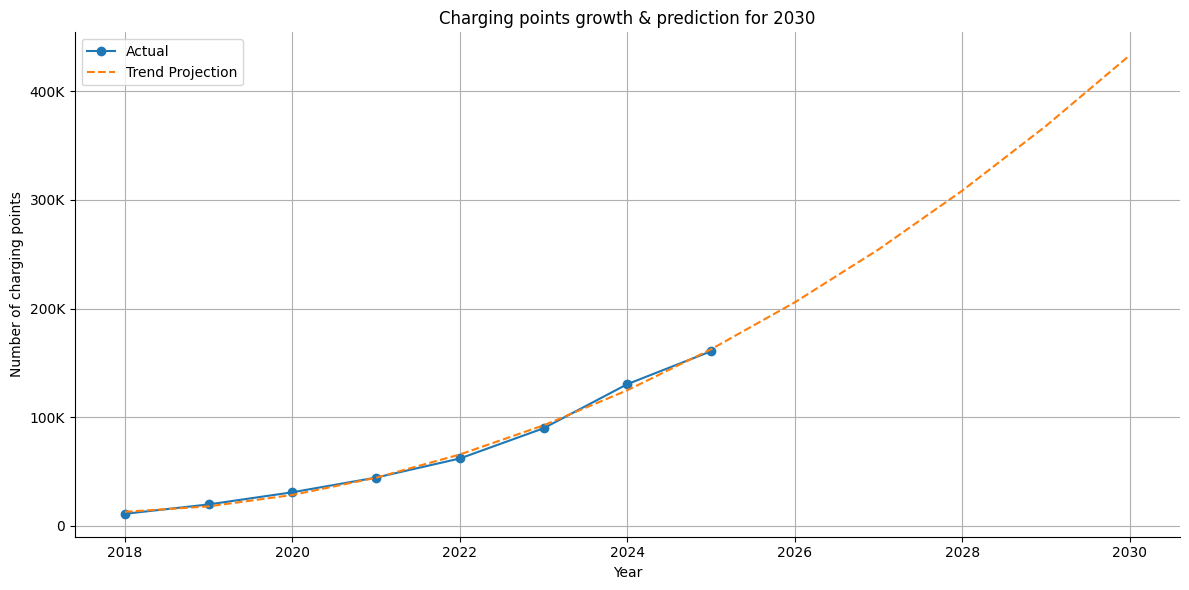

To reach 1,000,000 stations by 2030, Germany needs ~167,838 new stations per year from 2026.


In [20]:
df = df_germany.copy()

# Step 1: Polynomial regression for projection (e.g., degree 2 for quadratic)
X = df["year"].values.reshape(-1, 1)
y = df["number_of_charging_points"].values

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

# Step 2: Predict future values until 2030
future_years = np.arange(df["year"].min(), 2031).reshape(-1, 1)
future_years_poly = poly.transform(future_years)
predictions = model.predict(future_years_poly)

# Step 3: Calculate target gap
last_known_year = df["year"].max()
last_known_count = df[df["year"] == last_known_year]["number_of_charging_points"].values[0]
stations_needed = 1_000_000 - last_known_count
years_remaining = 2030 - last_known_year
stations_per_year_needed = stations_needed / years_remaining

plot_prediction(df, future_years)

# Print target info
print(f"To reach 1,000,000 stations by 2030, Germany needs ~{int(stations_per_year_needed):,} new stations per year from {last_known_year + 1}.")
